In [1]:
from collections import Counter
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision import transforms
import torchvision.datasets as datasets



print('done')

done


In [2]:
# mnist data reader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x11f1dd4a8>,
 <torch.utils.data.dataloader.DataLoader at 0x11f1dd630>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


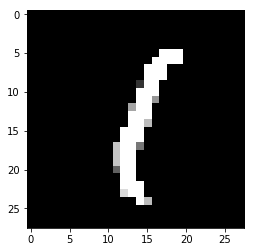

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


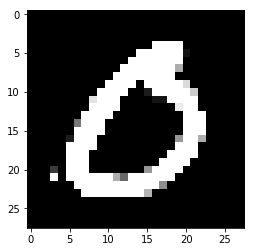

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


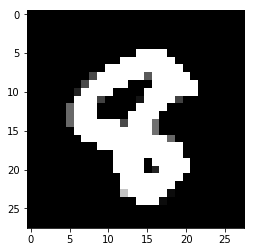

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


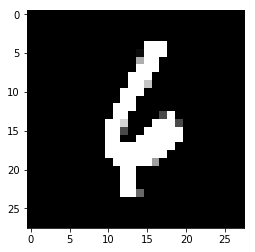

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


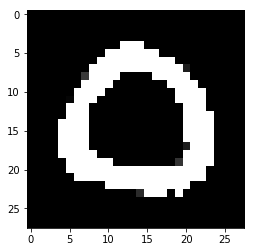

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


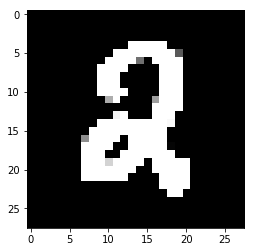

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


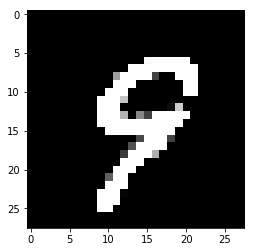

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


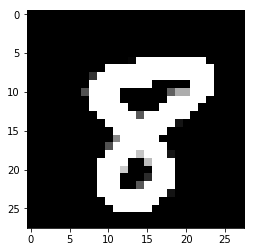

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


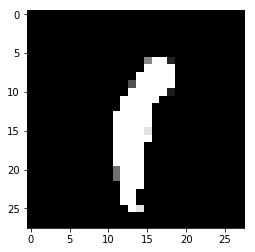

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


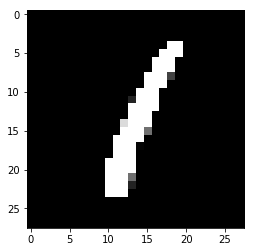

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


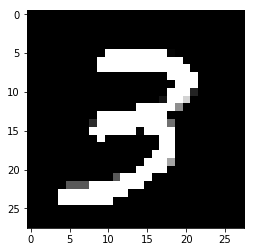

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


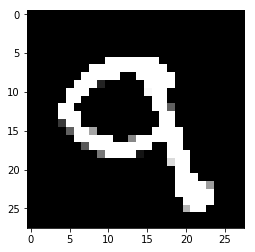

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


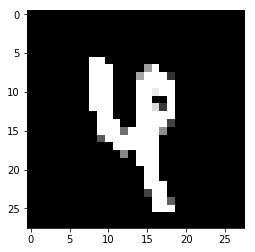

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


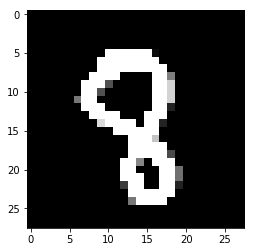

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


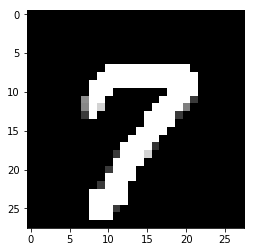

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


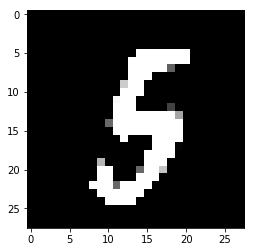

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


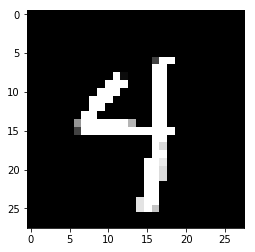

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


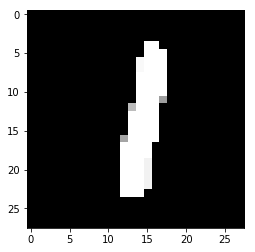

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


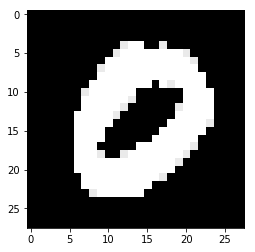

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


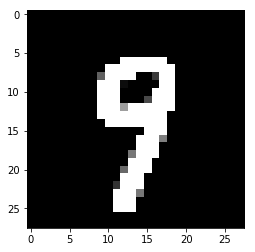

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


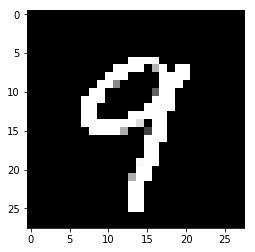

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


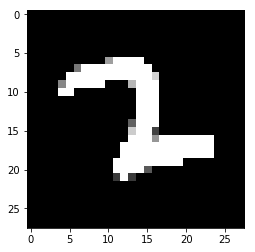

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


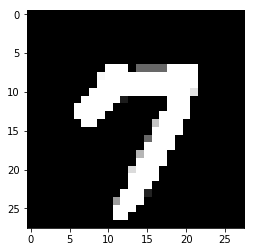

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


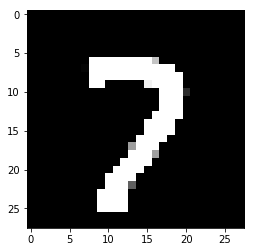

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


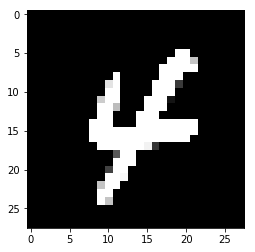

In [3]:
# mnist data reader

def gray_to_rgb(x):
    x = np.array(x[0,:,:]) 
    return torch.tensor(np.stack([x,x,x], axis = -1).reshape((3,28,28)))

normalize = transforms.Normalize((0.1307,0.1307,0.1307), (0.1307,0.1307,0.1307))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: gray_to_rgb(x) ),
    normalize
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 25

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

for i, (inputs, outputs) in enumerate(train_loader):
    for image in inputs.numpy():
        image = image.reshape((28,28,3))
        plt.imshow(image)
        plt.show()
    break

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(64 * 9, 120)
        self.fc2 = nn.Linear(120,120)
        self.encoding = nn.Linear(120,25)
        self.fc3 = nn.Linear(25,10)
        
        
    def forward(self, x):
        x = x.reshape((x.shape[0],3,28,28))
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = torch.relu(self.encoding(x))
        
        return self.fc3(encoded), encoded
        

    
classifier = Classifier()
classifier(torch.randn((10,3,28,28)))
classifier

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=120, bias=True)
  (encoding): Linear(in_features=120, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=10, bias=True)
)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum = 0.9)
print('done')

done


In [6]:
def fit(model, train_loader, metric, optimizer, epochs = 5, log_every = 100):
    for j in range(epochs):
        total = 0
        correct = 0
        losses = []
        for i, (inputs, outputs) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions, encoded = model(inputs)
            loss = metric(predictions, outputs)  
            loss += 0.001 * torch.sum(torch.abs(encoded))
            correct += sum(torch.max(predictions, -1)[1] == outputs).item()
            total += predictions.shape[0]
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if i%log_every == 0:
                print(j, np.mean(losses), correct/total)
                
fit(classifier, train_loader, criterion, optimizer, epochs = 5, log_every = 100)

0 2.34665846824646 0.08
0 2.308623101451609 0.12752475247524753
0 2.2967142097985564 0.14228855721393036
0 2.1840430383270366 0.20132890365448505
0 2.020133074530937 0.27361596009975064
0 1.855138602252016 0.34275449101796407
0 1.708056496106051 0.4086522462562396
0 1.5924556955971494 0.4570042796005706
0 1.4934799034199613 0.49927590511860176
0 1.4109480277150372 0.533496115427303
0 1.336796390664923 0.5648351648351648
0 1.2701663443654587 0.5927702089009991
0 1.215186185806022 0.6156203164029975
0 1.1644872625134342 0.6364335126825519
0 1.1199896522371535 0.6542184154175589
0 1.0801584426956443 0.6697135243171219
0 1.0442407040727057 0.6838226108682074
0 1.0138153192280042 0.6959200470311582
0 0.9833535425766252 0.7076957245974459
0 0.9588869089424328 0.7172856391372961
0 0.9360271348975886 0.7260169915042479
0 0.9129301933221509 0.7348310328415041
0 0.8895092882970852 0.7433893684688778
0 0.8687976361655091 0.7509778357235984
1 0.3189566135406494 0.96
1 0.39719876676502797 0.9180198

In [7]:
# Monitor accuracy in test and train 
# Quality monitoring visualizaing incorrect and correct in test and train
# Transfer learning
# Image augmentations
# Visualzaing what conv layers learn
# Visualize what activations learn

def evaluate(model, test_loader):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader):
        inputs, outputs = data
        predictions, encoded = model(inputs)
        predictions = torch.max(predictions, -1)[1]
        correct += sum(predictions == outputs).item()
        total += predictions.shape[0]
    return correct / total
        
        
evaluate(classifier, test_loader)

0.9329

In [13]:
from collections import defaultdict

d = defaultdict(list)
for j, (inputs, outputs) in enumerate(test_loader):
    predictions, encoded = classifier(inputs)
    
    for i, (image, output, rep) in enumerate(zip(inputs, outputs, encoded)):
        image = image.reshape((28,28,3))
        d[output.item()].append([image,rep.detach().numpy()])
    if j >= 5:
        break




FEATURE MAPS FOR DIGIT 0


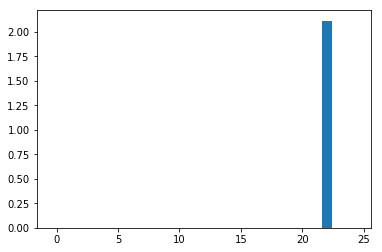

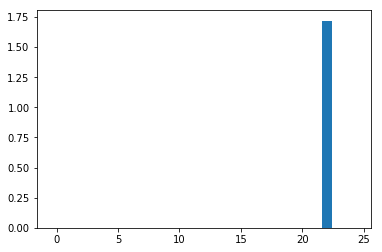

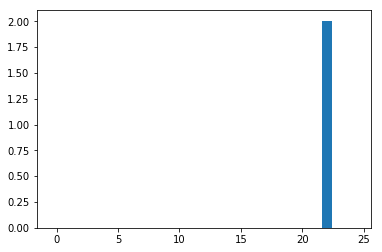

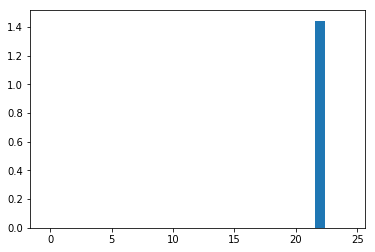

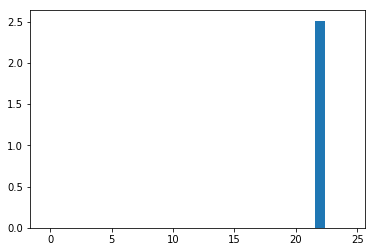

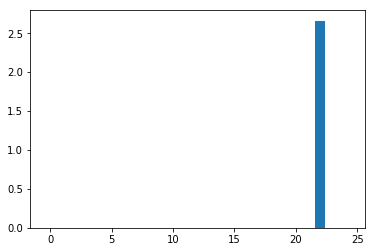

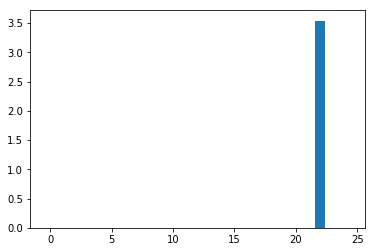

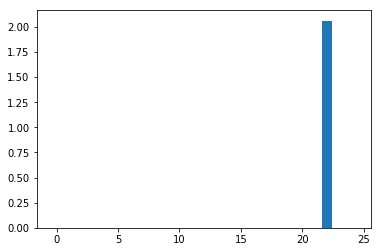

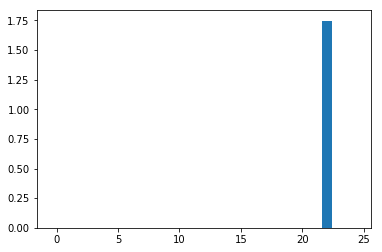

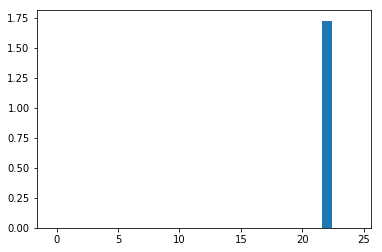

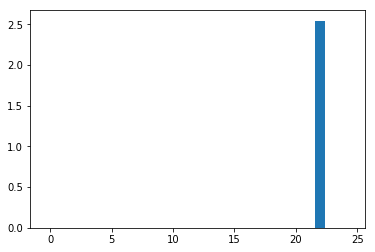

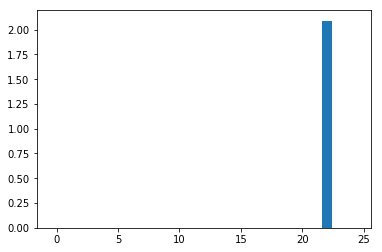

done


In [14]:
print('FEATURE MAPS FOR DIGIT', 0)
for (image,rep) in d[0]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')

FEATURE MAPS FOR DIGIT 1


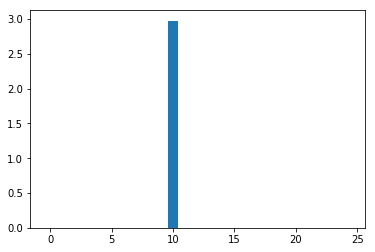

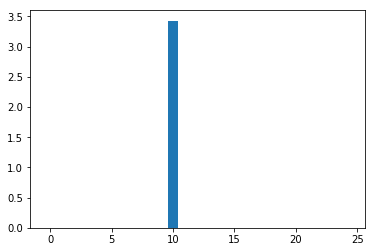

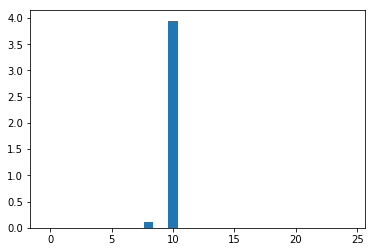

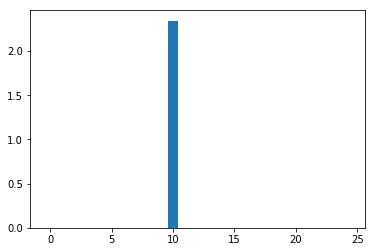

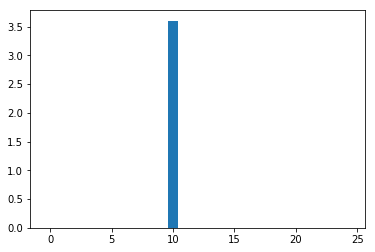

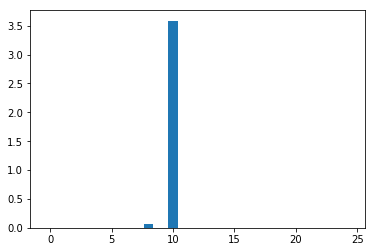

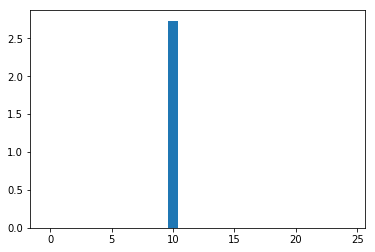

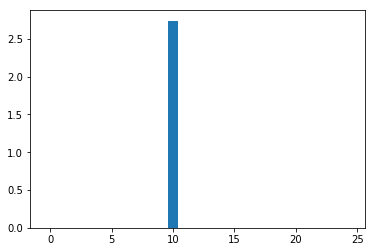

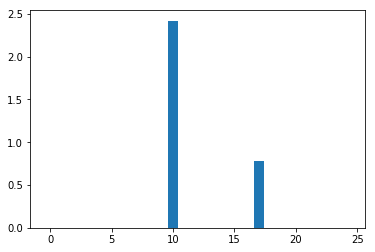

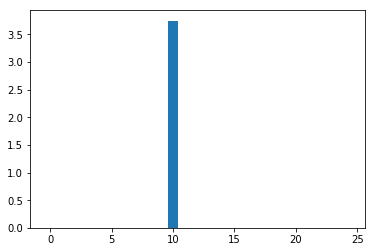

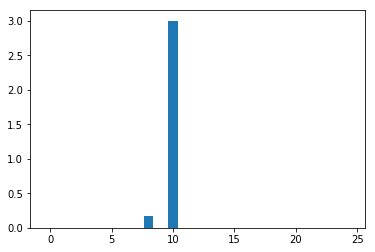

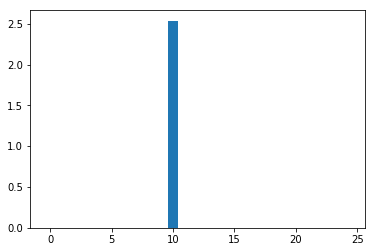

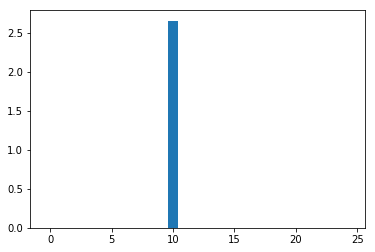

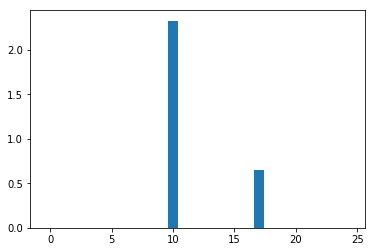

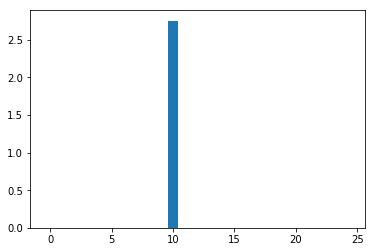

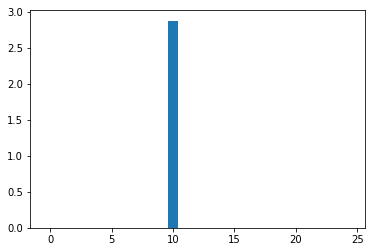

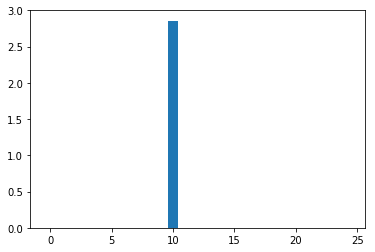

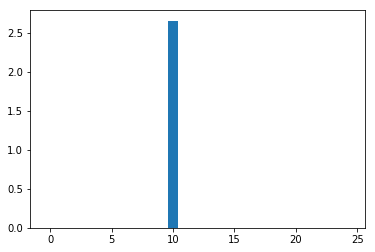

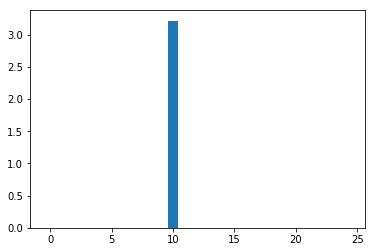

done


In [17]:
print('FEATURE MAPS FOR DIGIT', 1)
for (image,rep) in d[1]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')

FEATURE MAPS FOR DIGIT 2


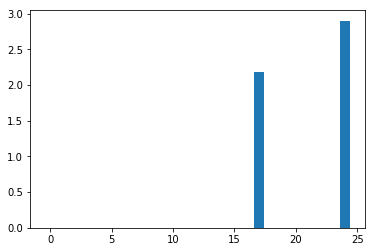

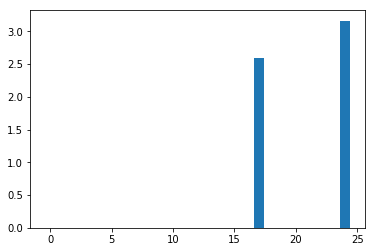

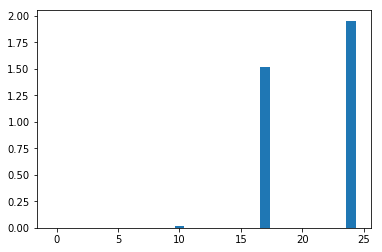

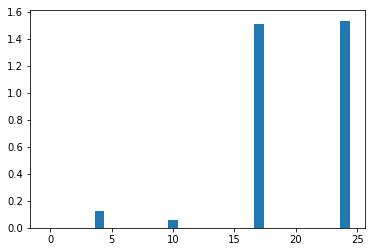

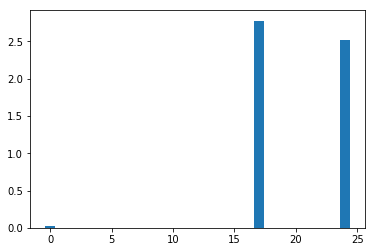

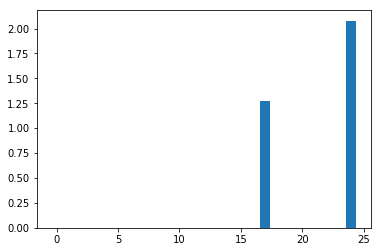

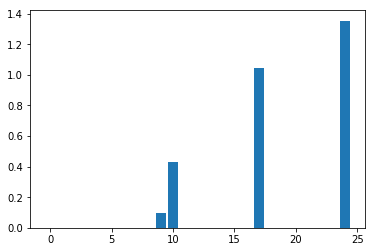

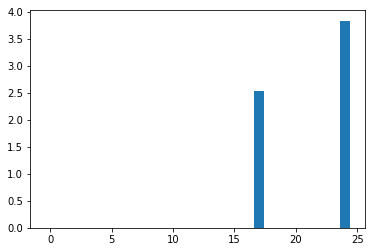

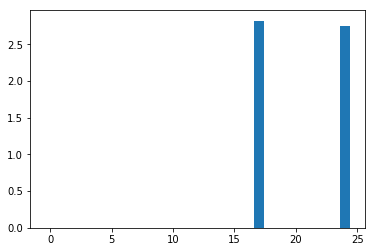

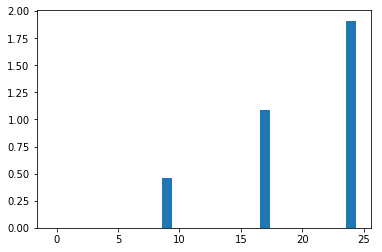

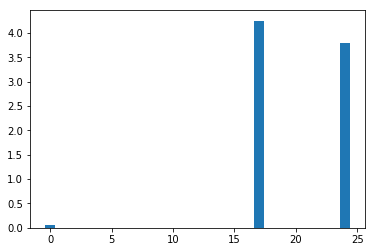

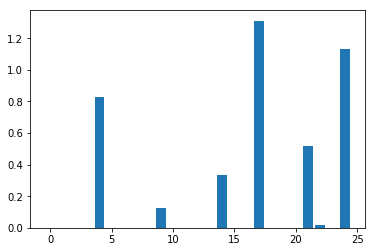

done


In [18]:
print('FEATURE MAPS FOR DIGIT', 2)
for (image,rep) in d[2]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')

FEATURE MAPS FOR DIGIT 3


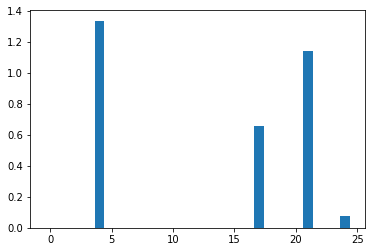

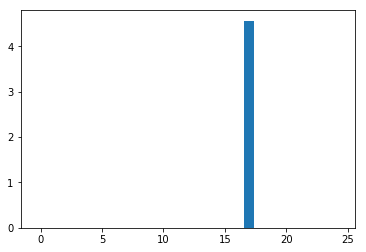

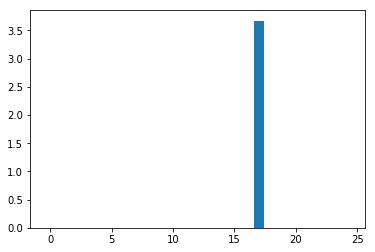

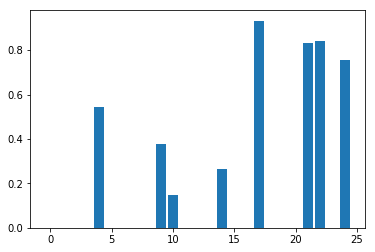

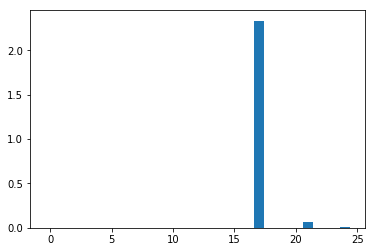

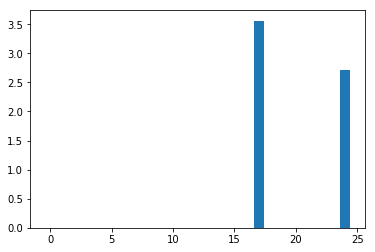

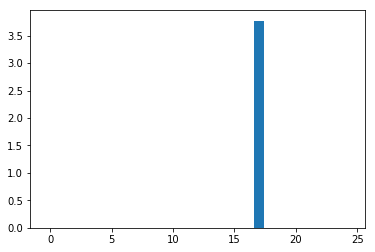

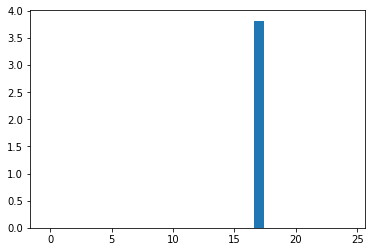

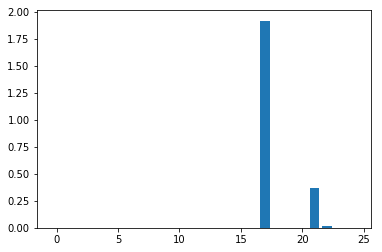

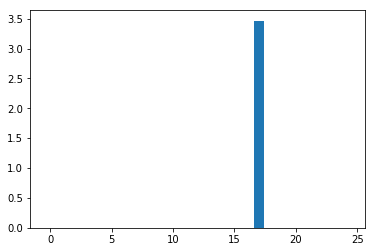

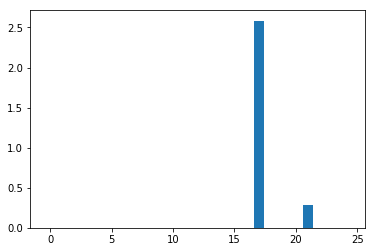

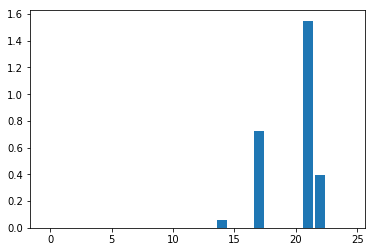

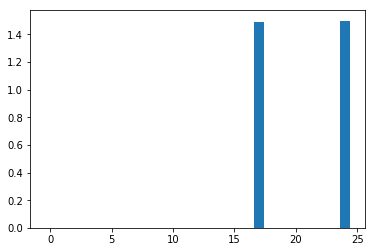

done


In [19]:
print('FEATURE MAPS FOR DIGIT', 3)
for (image,rep) in d[3]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')

FEATURE MAPS FOR DIGIT 8


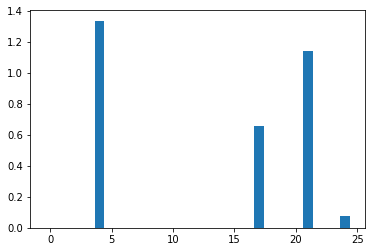

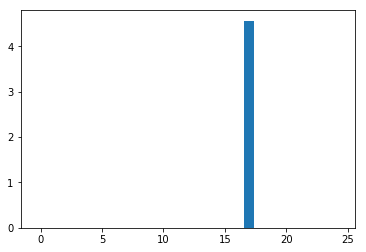

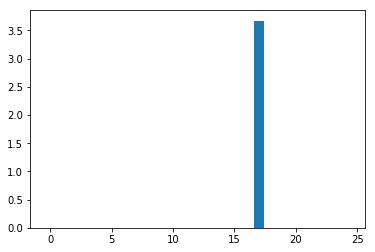

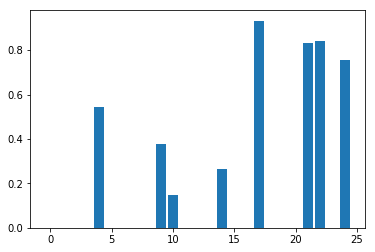

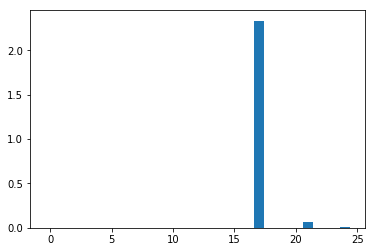

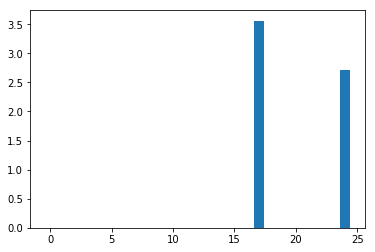

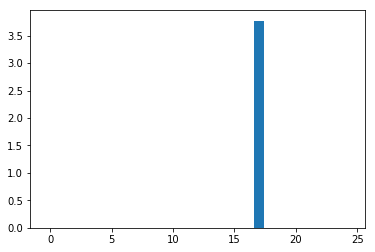

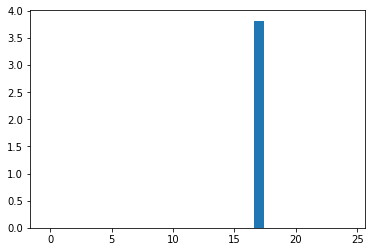

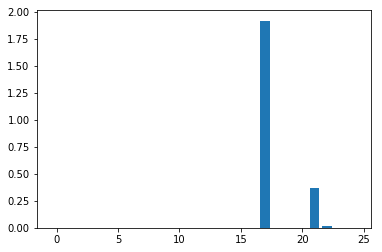

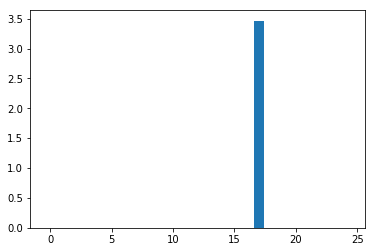

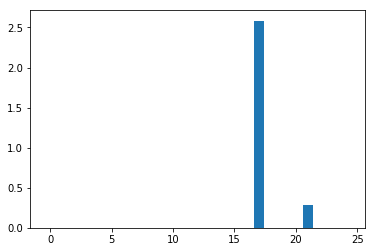

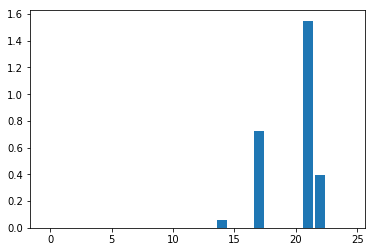

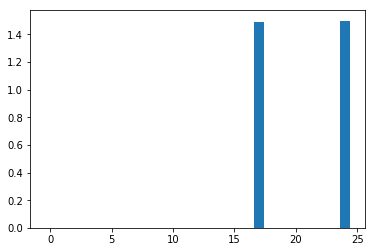

done


In [20]:
print('FEATURE MAPS FOR DIGIT', 8)
for (image,rep) in d[3]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')

FEATURE MAPS FOR DIGIT 4


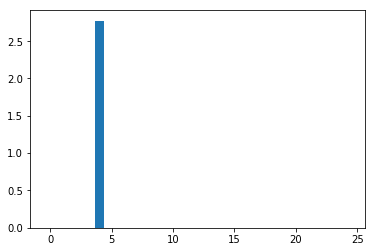

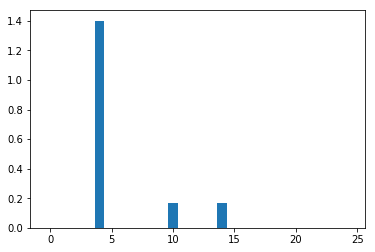

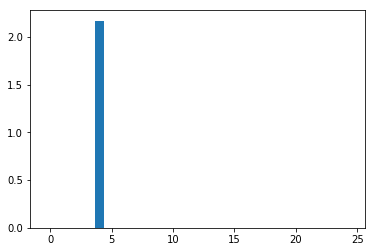

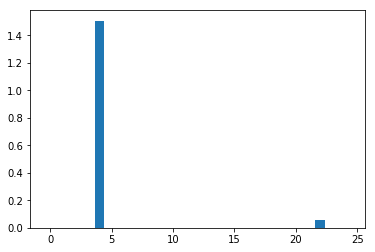

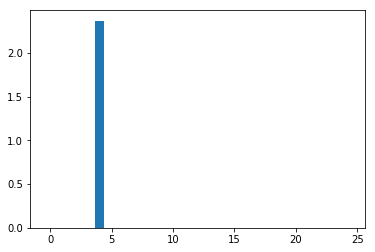

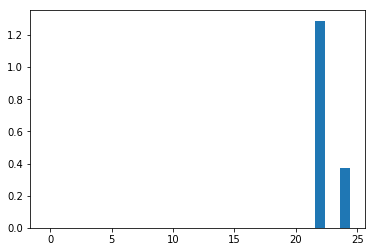

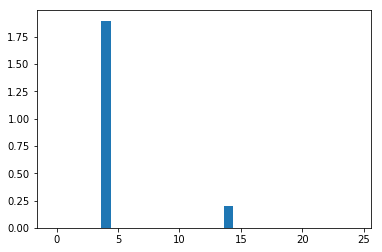

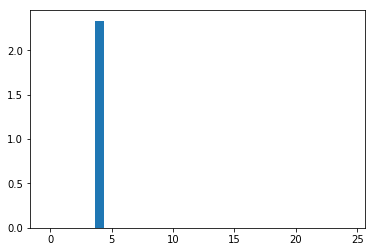

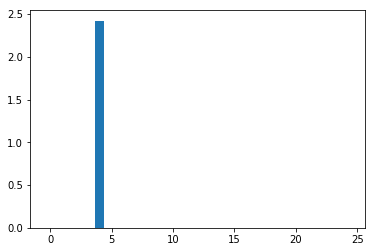

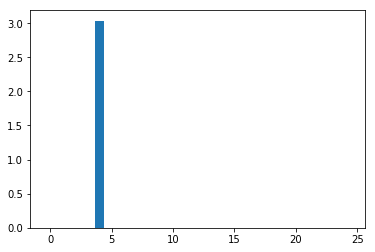

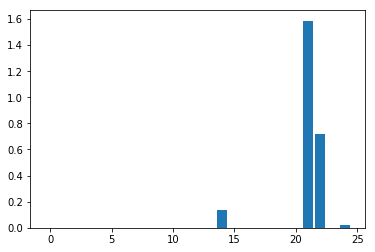

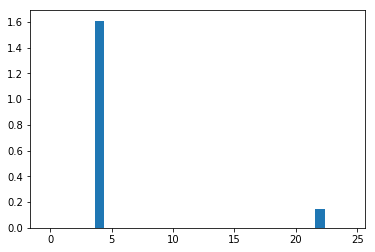

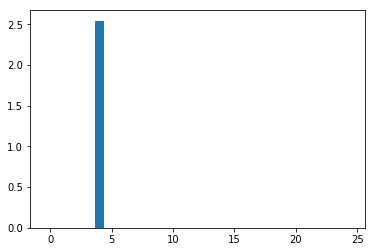

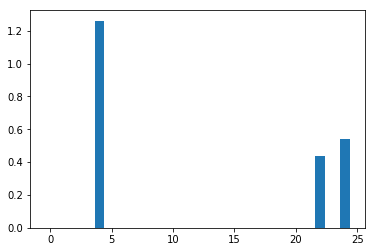

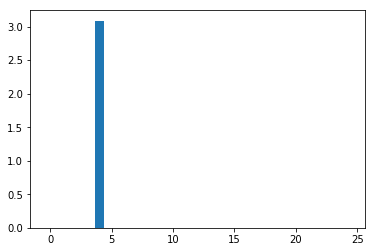

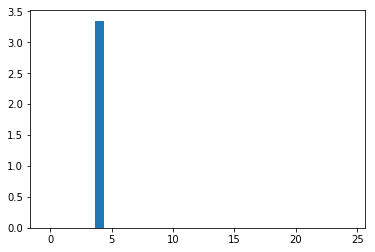

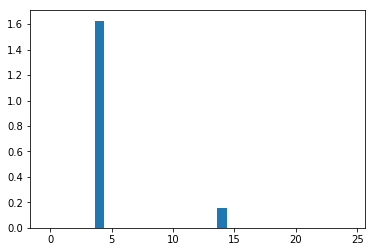

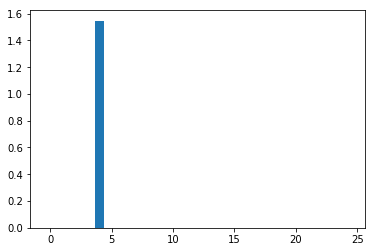

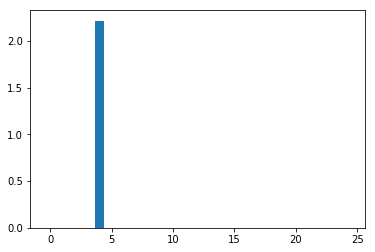

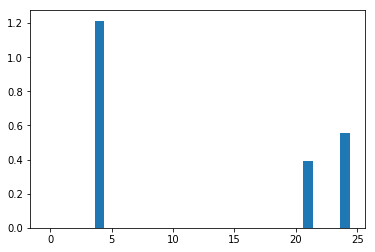

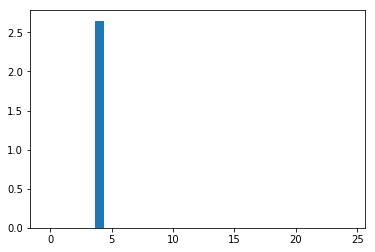

done


In [21]:
print('FEATURE MAPS FOR DIGIT', 4)
for (image,rep) in d[4]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')

FEATURE MAPS FOR DIGIT 5


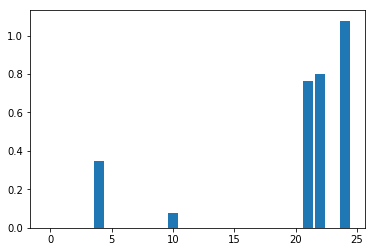

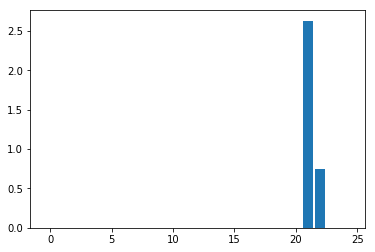

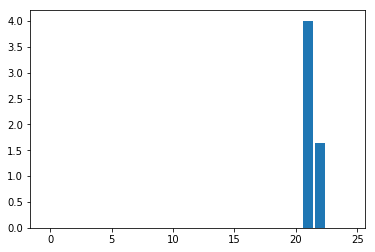

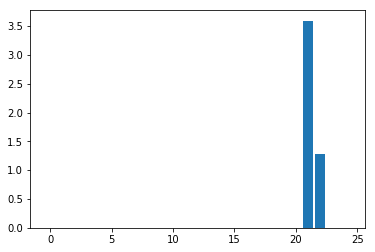

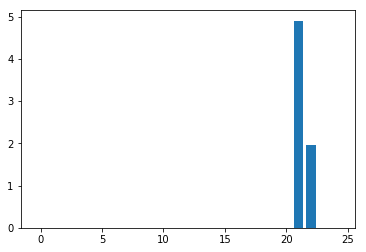

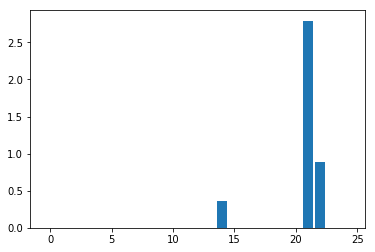

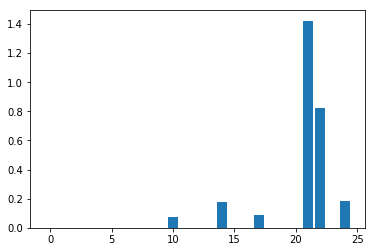

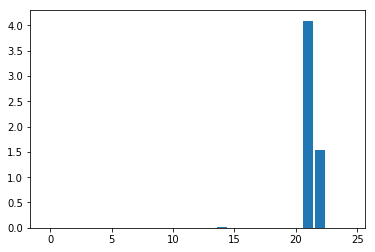

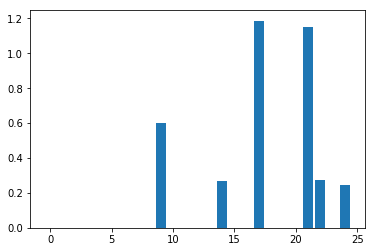

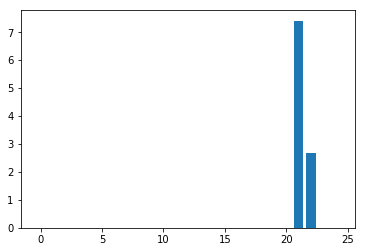

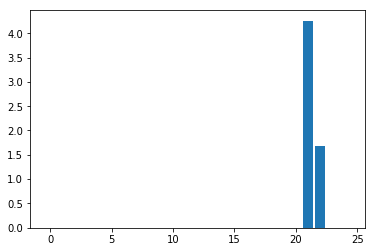

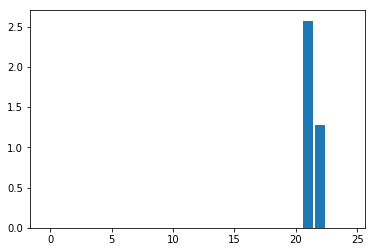

done


In [22]:
print('FEATURE MAPS FOR DIGIT', 5)
for (image,rep) in d[5]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')

FEATURE MAPS FOR DIGIT 6


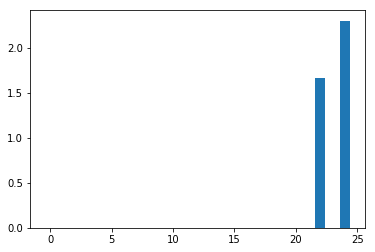

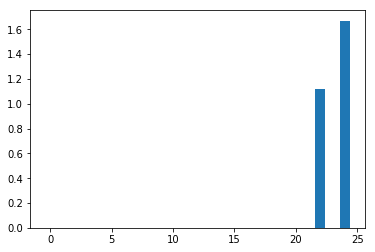

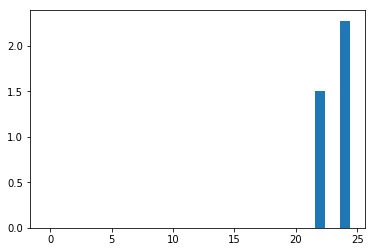

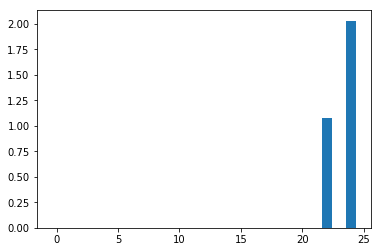

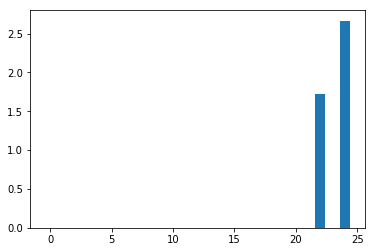

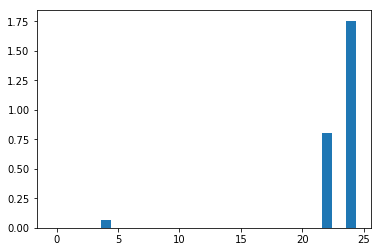

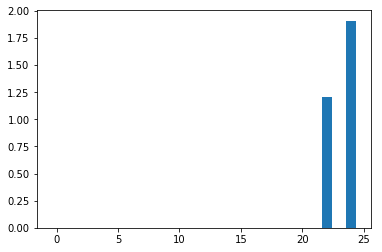

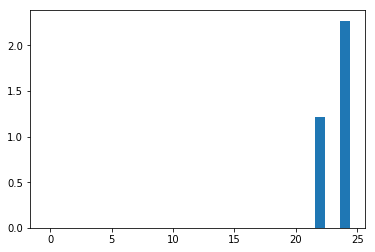

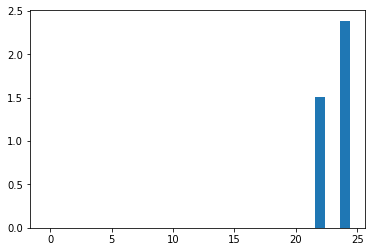

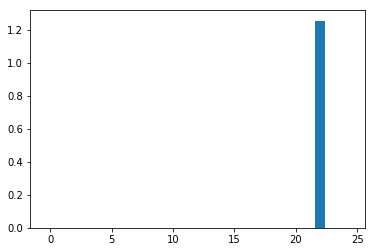

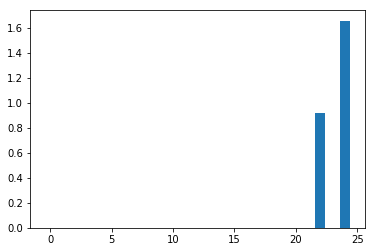

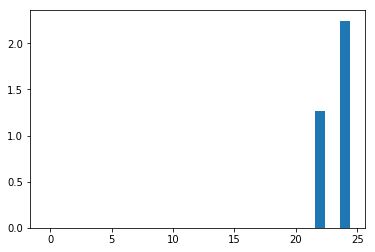

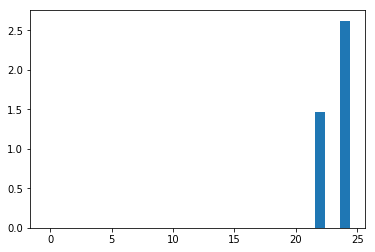

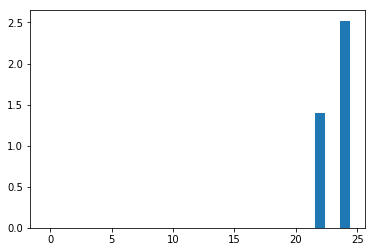

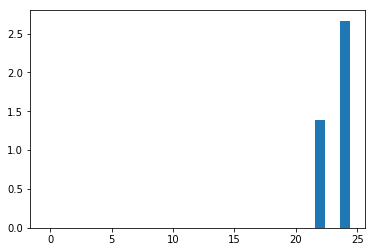

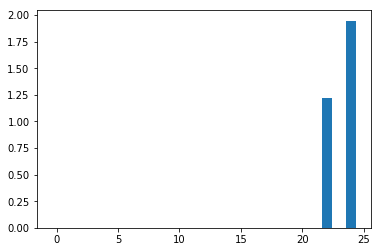

done


In [23]:
print('FEATURE MAPS FOR DIGIT', 6)
for (image,rep) in d[6]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')

FEATURE MAPS FOR DIGIT 7


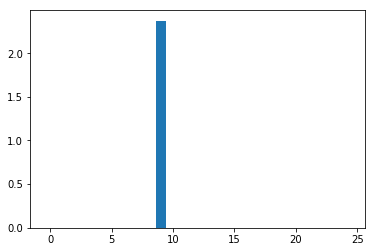

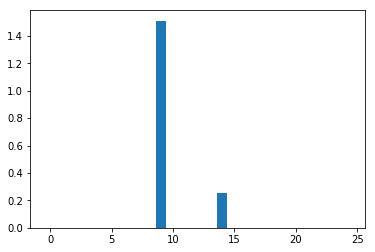

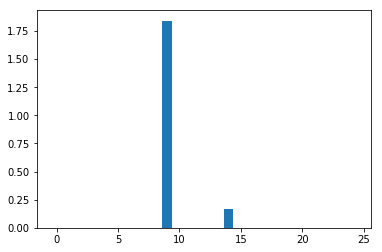

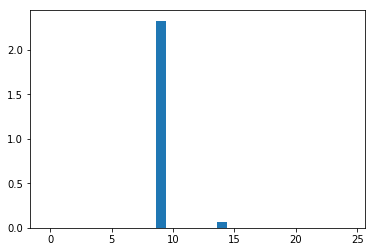

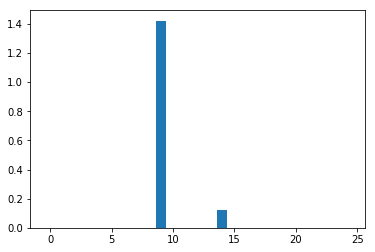

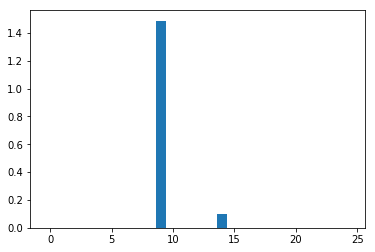

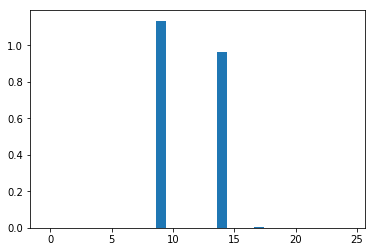

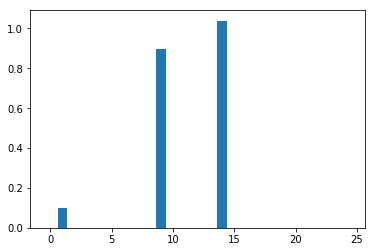

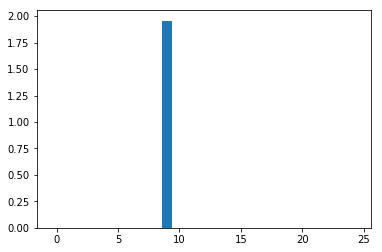

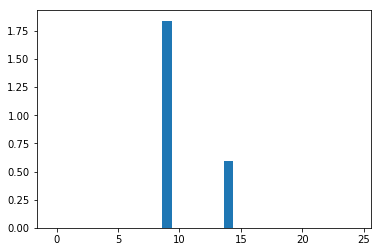

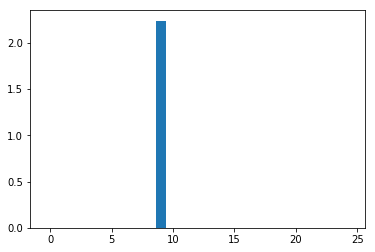

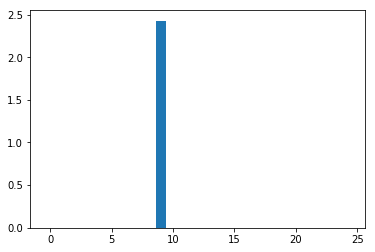

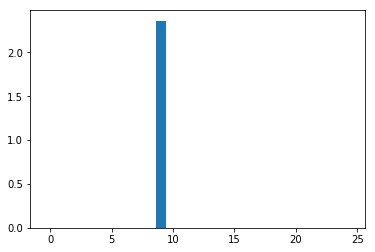

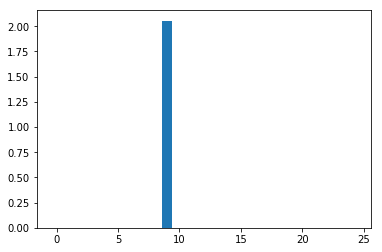

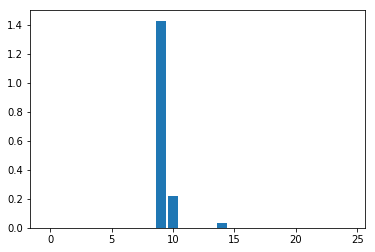

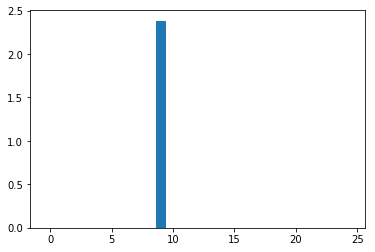

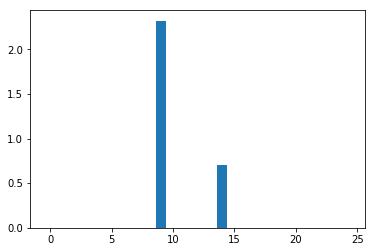

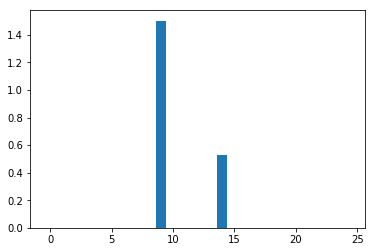

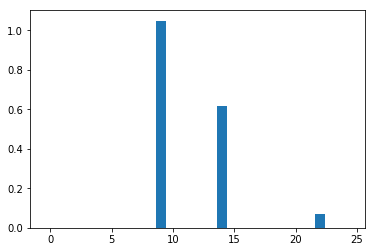

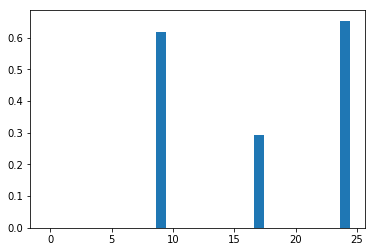

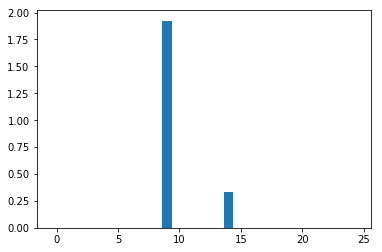

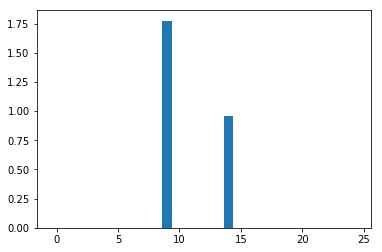

done


In [24]:
print('FEATURE MAPS FOR DIGIT', 7)
for (image,rep) in d[7]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')

FEATURE MAPS FOR DIGIT 9


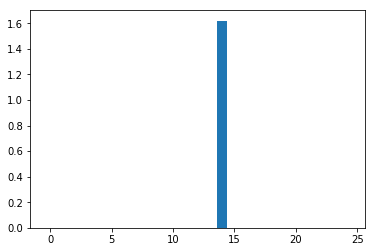

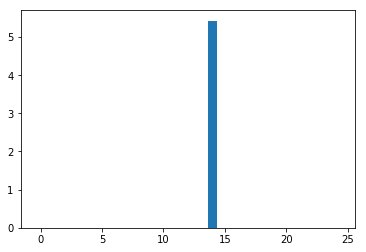

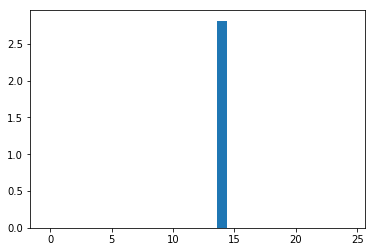

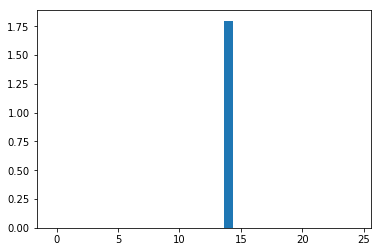

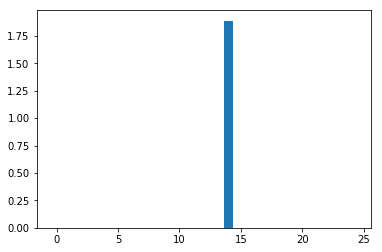

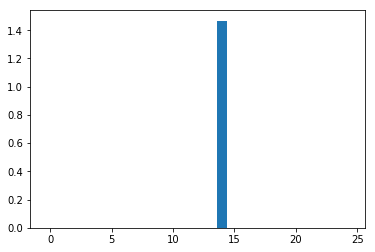

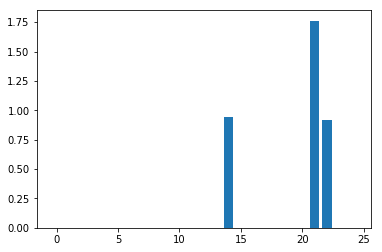

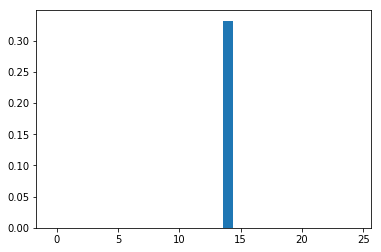

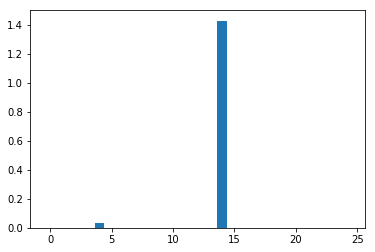

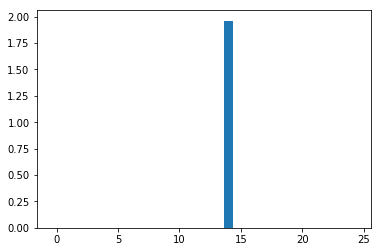

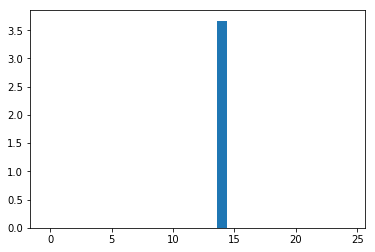

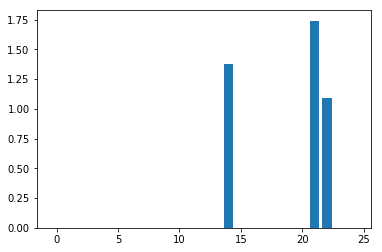

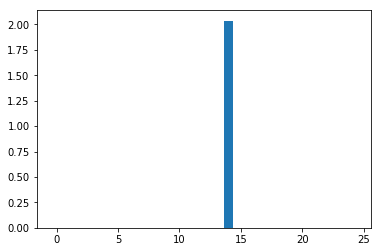

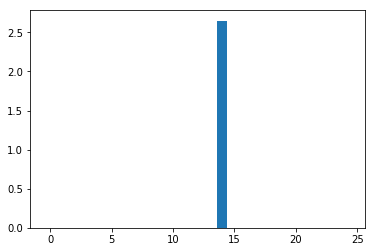

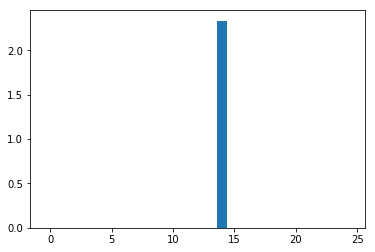

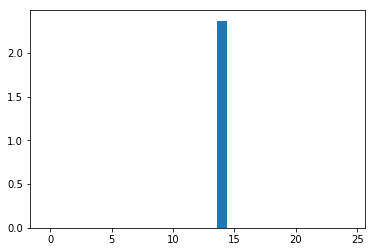

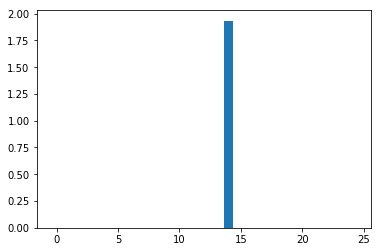

done


In [26]:
print('FEATURE MAPS FOR DIGIT', 9)
for (image,rep) in d[9]:
    plt.bar(range(0,25),rep)
    plt.show()
        
    
    
print('done')